<a href="https://colab.research.google.com/github/S-Asghari/Fact-Checking-Using-LLMs/blob/main/fine-tuning/BERT/BERT_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Libraries

In [2]:
!pip install transformers
from transformers import BertTokenizer, BertModel, BertForPreTraining, BertForSequenceClassification, EncoderDecoderModel, AdamW
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report
import matplotlib.pyplot as plt

# 1. Load data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Tokenize input

In [4]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [5]:
def bert_encoder(seq, tokenizer, max_length=128):
  encoding = tokenizer.encode(seq, max_length=max_length, padding="max_length", truncation=True)
  return encoding

# 3. Train and fine tune the model

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1).to(device)
# model.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
batch_size = 32   # 64 doesn't work for me :(

In [9]:
optimizer = AdamW(model.parameters(), lr=5e-5)  # Should I change the learning rate?

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
model.load_state_dict(torch.load('/content/drive/MyDrive/DeClare/bert_model(snopes).pth'))

<All keys matched successfully>

In [11]:
politifact_df = pd.read_csv('/content/drive/MyDrive/DeClare/PolitiFact.tsv', sep='\t', header=None)
politifact_df.columns = ['label', 'claim_id', 'claim', 'claim_source', 'text', 'article_source']
politifact_df.drop(['claim_id', 'claim_source', 'article_source'], axis=1, inplace=True)

In [12]:
# politifact_df['input'] = politifact_df['claim'] + bert_tokenizer.sep_token + politifact_df['text']
politifact_df['input'] = "Use the following text to discover the correctness of the claim at the end. Respond with either true or false." + bert_tokenizer.sep_token + politifact_df['text'] + bert_tokenizer.sep_token + politifact_df['claim']
politifact_df['input_tokens'] = politifact_df.input.apply(bert_encoder, tokenizer=bert_tokenizer)
pltfct_input, pltfct_label = politifact_df.input_tokens.to_list(), politifact_df.label.to_list()
pltfct_input = torch.tensor(pltfct_input).to(device)
pltfct_label = torch.tensor(pltfct_label).to(device)
pltfct_data = TensorDataset(pltfct_input, pltfct_label)
pltfct_loader = DataLoader(pltfct_data, batch_size=batch_size, shuffle=False)

In [13]:
probs = []
true_labels = []
with torch.no_grad():
    for input_batch, label_batch in pltfct_loader:
        outputs = model(input_ids=input_batch)
        prob = torch.sigmoid(outputs[0])
        probs.extend(prob.detach().cpu().numpy().tolist())  # Move probabilities to cpu before converting to numpy
        true_labels.extend(label_batch.cpu().numpy().tolist())  # Move labels to cpu before converting to numpy

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


In [14]:
true_labels = [int(label) for label in true_labels]
probs = [prob[0] for prob in probs]

In [15]:
fpr, tpr, _ = roc_curve(true_labels, probs)
roc_auc = auc(fpr, tpr)

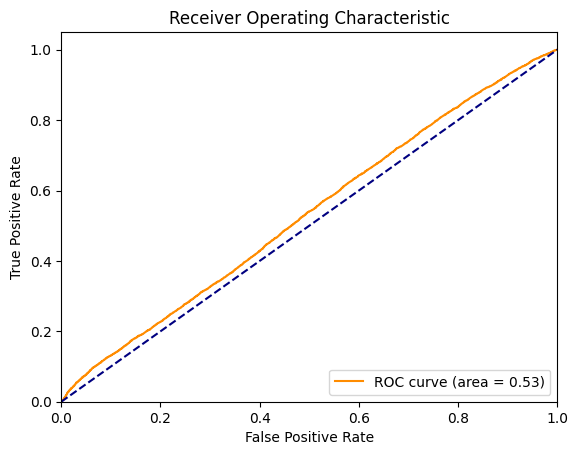

In [16]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [17]:
# Calculate PR AUC
precision, recall, _ = precision_recall_curve(true_labels, probs)
pr_auc = auc(recall, precision)

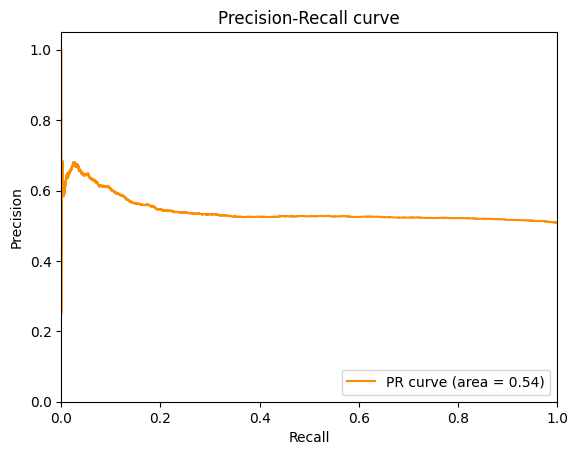

In [18]:
# Plot PR curve
plt.figure()
plt.plot(recall, precision, color='darkorange', label='PR curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower right")
plt.show()